In [1]:
import os
import numpy as np
np.set_printoptions(precision=1)
import nibabel as nib
import json
import matplotlib.image as mpimg
from os.path import join as opj
import matplotlib.pyplot as plt
import nipype.interfaces.fsl as fsl # importing FSL interface functions
from nilearn.plotting import plot_anat, plot_epi, view_img, plot_roi
from nipype import Node, Workflow  # components to construct workflow
from bids.layout import BIDSLayout  # BIDSLayout object to specify file(s)
from nilearn.image import mean_img, resample_img, resample_to_img

In [2]:
%matplotlib inline
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, FNIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold, Merge, ApplyWarp)
from nipype.interfaces.afni import Refit, Volreg, SkullStrip
from nipype.interfaces.ants import RegistrationSynQuick, Registration, ApplyTransforms
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect

In [3]:
def get_affine(path_to_file):
    return nib.load(path_to_file).affine
def get_voxel_dim(path_to_file):
    return nib.load(path_to_file).header.get_zooms()
def get_shape(path_to_file):
    return nib.load(path_to_file).shape

In [4]:
os.environ[ "ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS" ] = "7"

In [5]:
# Directory where your data set resides.
atlas_dir = '/data/atlas/'

mouse_dir = '/data/testDS/mouse_main/'

bids_dir = opj(mouse_dir,'bids')

output_dir = opj(mouse_dir, 'output')

working_dir = 'working_dir'

import shutil

if os.path.exists(output_dir):
    try:
        shutil.rmtree(output_dir)
    except OSError as e:
        print("Error: %s : %s" % (output_dir, e.strerror))
else:
    os.mkdir(output_dir)

In [6]:
# Creating the layout object for this BIDS data set
layout = BIDSLayout(bids_dir)

subjects = layout.get_subjects()
acquisitions = layout.get_acquisitions()
tasks = layout.get_tasks()
sessions = layout.get_sessions()
runs = layout.get_runs()

print(f"subjects - {subjects}, \nsessions - {sessions},\nacquisitions - {acquisitions}, \ntasks - {tasks}, \nruns - {runs}")

subjects - ['01'], 
sessions - ['20201203'],
acquisitions - ['FLASH', 'EPI'], 
tasks - ['4W'], 
runs - [4, 5]


In [7]:
#Assigning filenames and JSON randon file for TR
if acquisitions[0] == 'EPI':
    EPI_files = layout.get(subject=subjects, acquisition=acquisitions[0], extensions=['nii.gz'], return_type='file')
    FLASH_files = layout.get(subject=subjects, acquisition=acquisitions[1], extensions=['nii.gz'], return_type='file')
else:
    FLASH_files = layout.get(subject=subjects, acquisition=acquisitions[0], extensions=['nii.gz'], return_type='file')
    EPI_files = layout.get(subject=subjects, acquisition=acquisitions[1], extensions=['nii.gz'], return_type='file')
print(f'Number of functional images: {len(EPI_files)} \nNumber of anatomical images: {len(FLASH_files)}')

Number of functional images: 2 
Number of anatomical images: 1


In [8]:
# Smoothing widths to apply
smooth_kernel = [0.5]
    
TR = 1.0
print(f'Repetion time is: {TR}')

Repetion time is: 1.0


In [9]:
print('EPI vox dims\n',get_voxel_dim(EPI_files[0]), '\nEPI shape\n',get_shape(EPI_files[0]), 
      '\nFLASH vox dims\n', get_voxel_dim(FLASH_files[0]),'\nFLASH shape\n', get_shape(FLASH_files[0]), 
      '\nAtlas vox dims\n', get_voxel_dim(opj(atlas_dir, 'scaled_template.nii.gz')), 
      '\nAtlas & Labels shape\n', get_shape(opj(atlas_dir, 'scaled_template.nii.gz')))

EPI vox dims
 (0.15625, 0.15625, 0.5, 1.0) 
EPI shape
 (96, 48, 12, 120) 
FLASH vox dims
 (0.0625, 0.0625, 0.25) 
FLASH shape
 (256, 128, 30) 
Atlas vox dims
 (0.039785154, 0.1311, 0.07957031) 
Atlas & Labels shape
 (257, 151, 95)


In [10]:
#PIPELINE for DATA Preparation

In [11]:
# 1 Scale N (scale_factor) times EPI images
scale_factor = 30

# 1.1.1 Scale N times EPI images
scaler_func = Node(Refit(  deoblique=True,
                      xyzscale=scale_factor),
                 name = 'scaler_func')

# 1.1.2 Scale N times ANAT images
scaler_anat = Node(Refit(   deoblique=True,
                         xyzscale=scale_factor),
                 name = 'scaler_anat')

# 1.1.3 Scale N times merged EPI image
scaler_mean = Node(Refit(deoblique=True,
                         xyzscale=scale_factor),
                 name = 'scaler_mean')

# 1.1.4 Scale N times ATLAS image
scaler_atlas = Node(Refit( xyzscale=scale_factor),
                 name = 'scaler_atlas')

# 1.1.5 Scale N times LABELS image
scaler_labels = Node(Refit( xyzscale=scale_factor),
                 name = 'scaler_labels')

# 1.1.4 Merge together multiple EPI files
merger = Node(Merge(in_files = EPI_files,
                    dimension = 't',
                    tr = TR),
                 name='merger')

# 1.2 Get mean EPI image for coregistration with ANAT and as a referense to mc of separate EPIs
mcflirt_func_merged = Node(MCFLIRT(ref_vol=70,
                       save_plots=True,
                       dof = 6,
                       mean_vol=True,
                       smooth = 0.0,
                       cost = 'normmi',
                       output_type='NIFTI_GZ'),
                 name="mcflirt_func_merged")

#Working with EPI data
# 2.1.0 MCFLIRT - motion correction for EPI images with output of 1.2 as a referense
mcflirt_func = Node(MCFLIRT(save_plots=True,
                       smooth = 0.0,
                       cost = 'normmi',
                       dof = 6,
                           ),
                 name="mcflirt_func")

# 2.1.1 ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=10, 
                          t_size=-1, 
                          output_type='NIFTI_GZ'),
                 name="extract")

# 2.1.2 SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             time_repetition=TR),
                 name="slicetimer")

# 3.1.0 Skull strip node
anat_brain_extraction = Node(BET(output_type='NIFTI_GZ'),
                 name='anat_brain_extraction')

# 3.1.0 Skull strip node
func_mean_brain_extraction = Node(BET(output_type='NIFTI_GZ'),
                 name='func_mean_brain_extraction')

# creating co-registration node (estimating the coregistration parameters)
func2anat_linear = Node(FLIRT(  # target: FLASH - weighted
                       dof=6,
                       cost = 'normmi',
                       interp ='nearestneighbour',
                       output_type='NIFTI_GZ'), 
                 name="func2anat_linear")

# creating co-registration node (estimating the coregistration parameters)
anat2atlas_linear = Node(FLIRT(  # target: FLASH - weighted
                       dof=12,
                       cost = 'normmi', # normizied mutual info
                       interp ='spline',
                       output_type='NIFTI_GZ'), 
                 name="anat2atlas_linear")

# applying the coregistration parameters to the entire time series
applywarp_func2anat = Node(ApplyWarp(#interp='trilinear',
                          output_type='NIFTI_GZ'),
                 name="applywarp_func2anat")

applywarp_func2anat_mean = Node(ApplyWarp(#interp='trilinear',
                          output_type='NIFTI_GZ'),  
                 name="applywarp_func2anat_mean")

applywarp_func2atlas = Node(ApplyWarp(#interp='trilinear',
                          output_type='NIFTI_GZ'),
                 name="applywarp_func2atlas")

applywarp_func2atlas_mean = Node(ApplyWarp(#interp='trilinear',
                          output_type='NIFTI_GZ'),  
                 name="applywarp_func2atlas_mean")

quickRegSyn = Node(RegistrationSynQuick(num_threads=5,
                                        transform_type='sr'),
                  name='quickRegSyn')

# Smooth - image smoothing
#smooth = Node(Smooth(fwhm=smooth_kernel),
#              name="smooth")



# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=output_dir),
                name="datasink")


#afni_mc_func = Node(Volreg(interp = 'linear', outputtype = 'NIFTI', zpad = 1,  num_threads=4, in_weight_volume = (EPI_files[1], 70)),
#                   name='motion_corr_func')

#afni_mc_func_mean = Node(Volreg(interp = 'linear', outputtype = 'NIFTI', zpad = 1,  num_threads=4, in_weight_volume = (EPI_files[1], 70)),
#                   name='motion_corr_func_merged')

In [12]:
#FLIRT.help()

In [57]:
## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 #('_run_', 'run-'),
                 ('_task_name_', '/task-'),
                 #('_session_', '/ses-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii.gz_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
#subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in smooth_kernel]
#substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [58]:
# Data iterator
# Infosource - a function free node to iterate over the list of subject names
infosource_func = Node(IdentityInterface(fields=['subject_id', 'task_name', 'run']),
                  name="infosource_epi")
infosource_func.iterables = [('subject_id', subjects), ('task_name', tasks), ('run', runs)]

infosource_anat = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource_anat")
infosource_anat.iterables = [('subject_id', subjects)]

#SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'ses-20201203_ATLAS', 'anat', 
                'sub-{subject_id}_ses-20201203_ATLAS_acq-FLASH_T1w.nii.gz')

func_file = opj('sub-{subject_id}', 'ses-20201203_ATLAS', 'func',
                'sub-{subject_id}_ses-20201203_ATLAS_task-{task_name}_acq-EPI_run-{run}_bold.nii.gz')

atlas =  opj(atlas_dir, 'scaled_template.nii.gz')
labels = opj(atlas_dir, 'scaled_labels.nii.gz')

templates_func = {'func': func_file}

templates_anat = {'anat': anat_file}


templates_atlas = {'atlas': atlas,
                  'labels': labels}


selectfiles_func = Node(SelectFiles(templates_func, 
                               base_directory=bids_dir), name="selectfiles_func")

selectfiles_anat = Node(SelectFiles(templates_anat, 
                               base_directory=bids_dir), name="selectfiles_anat")

selectfiles_atlas = Node(SelectFiles(templates_atlas, 
                               base_directory=bids_dir), name="selectfiles_atlas")

In [59]:
#Functional data preparation
epiPrep = Workflow(name='epiPrep', base_dir=opj(output_dir, working_dir))

In [60]:
epiPrep.connect([( scaler_func, extract,      [('out_file','in_file')]), #Scaled data passed to extract dummy scans
                 ( extract, mcflirt_func,     [('roi_file','in_file')]), #Motion correct EPI images
                 ( mcflirt_func, slicetimer,  [('out_file','in_file')]), #MC EPI correction for slice-time acquisition
                ])

In [61]:
#Antomical data preparation
anatPrep = Workflow(name='anatPrep', base_dir=opj(output_dir, working_dir))

In [62]:
anatPrep.connect([( scaler_anat, anat_brain_extraction, [('out_file','in_file')]), #Scaled data passed to extract brain
                 ])

In [63]:
#Merged functional data preparation
epiMergedPrep = Workflow(name='epiMergedPrep', base_dir=opj(output_dir, working_dir))

In [64]:
epiMergedPrep.connect([( merger, scaler_mean,                             [('merged_file','in_file')]),
                       ( scaler_mean, mcflirt_func_merged,                [('out_file','in_file')]),
                       ( mcflirt_func_merged, func_mean_brain_extraction, [('mean_img','in_file')]),
                      ])

In [65]:
#Fast coregistration workflow
FUNC2ATLAS = Workflow(name='FUNC2ATLAS', base_dir=opj(output_dir, working_dir))

In [66]:
# Connect all components of the coregistration workflow
FUNC2ATLAS.connect([( func2anat_linear, applywarp_func2anat,               [('out_matrix_file', 'premat')]),
                    ( func2anat_linear, applywarp_func2anat_mean,          [('out_matrix_file', 'premat')]),
                    ( applywarp_func2anat, applywarp_func2atlas,           [('out_file', 'in_file')]),
                    ( applywarp_func2anat_mean, applywarp_func2atlas_mean, [('out_file', 'in_file')]),
                   ])

In [67]:
#Creating pipeline
prepFlow = Workflow(name='prepFlow', base_dir=opj(output_dir, working_dir))

In [68]:
#Connecting nodes
prepFlow.connect([( infosource_func, selectfiles_func,       [('subject_id','subject_id'),('task_name','task_name'),('run','run')]),
                  ( infosource_anat, selectfiles_anat,       [('subject_id','subject_id')]),
                  
                  
                  ( selectfiles_func, epiPrep,          [('func','scaler_func.in_file')]),
                  ( selectfiles_anat, anatPrep,         [('anat','scaler_anat.in_file')]),
                  
                  
                  ( selectfiles_atlas, scaler_atlas,          [('atlas', 'in_file')]),
                  ( selectfiles_atlas, scaler_labels,         [('labels','in_file')]),
                  
                  ( epiMergedPrep, FUNC2ATLAS,     [('func_mean_brain_extraction.out_file','func2anat_linear.in_file'),    #Apply warp on mean concat EPI image 
                                                    ('func_mean_brain_extraction.out_file','applywarp_func2anat_mean.in_file')]),  #Mean concat EPI image as an input  
                  
                  ( anatPrep, FUNC2ATLAS,          [('anat_brain_extraction.out_file','func2anat_linear.reference'),
                                                    ('anat_brain_extraction.out_file','applywarp_func2anat_mean.ref_file'),
                                                    ('anat_brain_extraction.out_file','applywarp_func2anat.ref_file')]),
                  
                  ( scaler_atlas, anat2atlas_linear, [('out_file','reference')]),
                  ( anatPrep, anat2atlas_linear,     [('anat_brain_extraction.out_file','in_file')]),
                  
                
                  ( anat2atlas_linear, FUNC2ATLAS,  [('out_file',       'applywarp_func2atlas_mean.ref_file'), 
                                                     ('out_file',       'applywarp_func2atlas.ref_file'),
                                                     ('out_matrix_file','applywarp_func2atlas_mean.premat'),
                                                     ('out_matrix_file','applywarp_func2atlas.premat')]),
                  
                  
                  
                  ( epiPrep, FUNC2ATLAS,           [('slicetimer.slice_time_corrected_file','applywarp_func2anat.in_file')]), #Apply warp on EPI TS 
                  ( epiMergedPrep, epiPrep,        [('mcflirt_func_merged.mean_img',        'mcflirt_func.ref_file')]),  #Mean concat EPI image as an input  
                  
                  
                  #DATASINK
                  ( FUNC2ATLAS, datasink,          [('func2anat_linear.out_matrix_file',    'func2anat.@func2anat_mat_file'),
                                                    ('applywarp_func2anat_mean.out_file',   'mean2anat_warped'),
                                                    ('applywarp_func2atlas_mean.out_file',  'mean2atlas_warped'),
                                                    ('applywarp_func2atlas.out_file',       'func2atlas_warped'),
                                                    ('applywarp_func2anat.out_file',        'func2anat.@func2anat_warped')]),
                  
                  ( scaler_atlas, datasink,         [('out_file', 'atlas.@atlas')]),
                  ( scaler_labels, datasink,        [('out_file', 'atlas.@labels')]),
                  #( , , [('',''),('','')]),
                 ])

210101-10:03:43,203 nipype.workflow INFO:
	 Generated workflow graph: /data/testDS/mouse_main/output/working_dir/prepFlow/graph.png (graph2use=colored, simple_form=True).


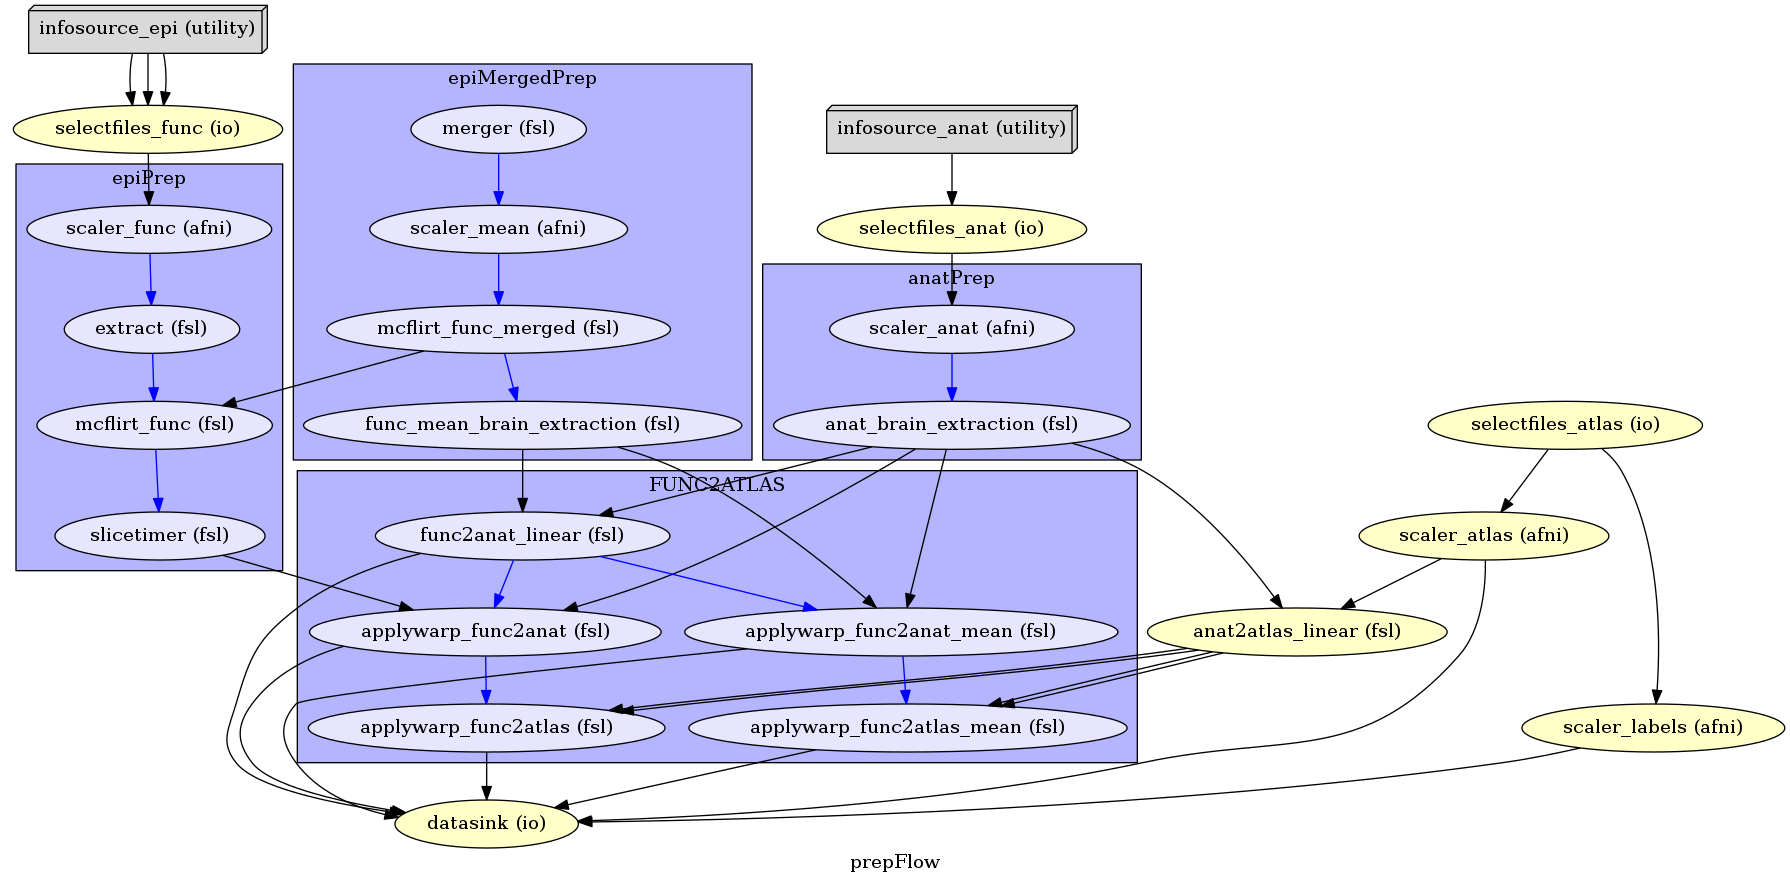

In [69]:
# Create preproc output graph
prepFlow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(prepFlow.base_dir, 'prepFlow', 'graph.png'))

210101-10:03:44,738 nipype.workflow INFO:
	 Generated workflow graph: /data/testDS/mouse_main/output/working_dir/prepFlow/graph_detailed.png (graph2use=flat, simple_form=False).


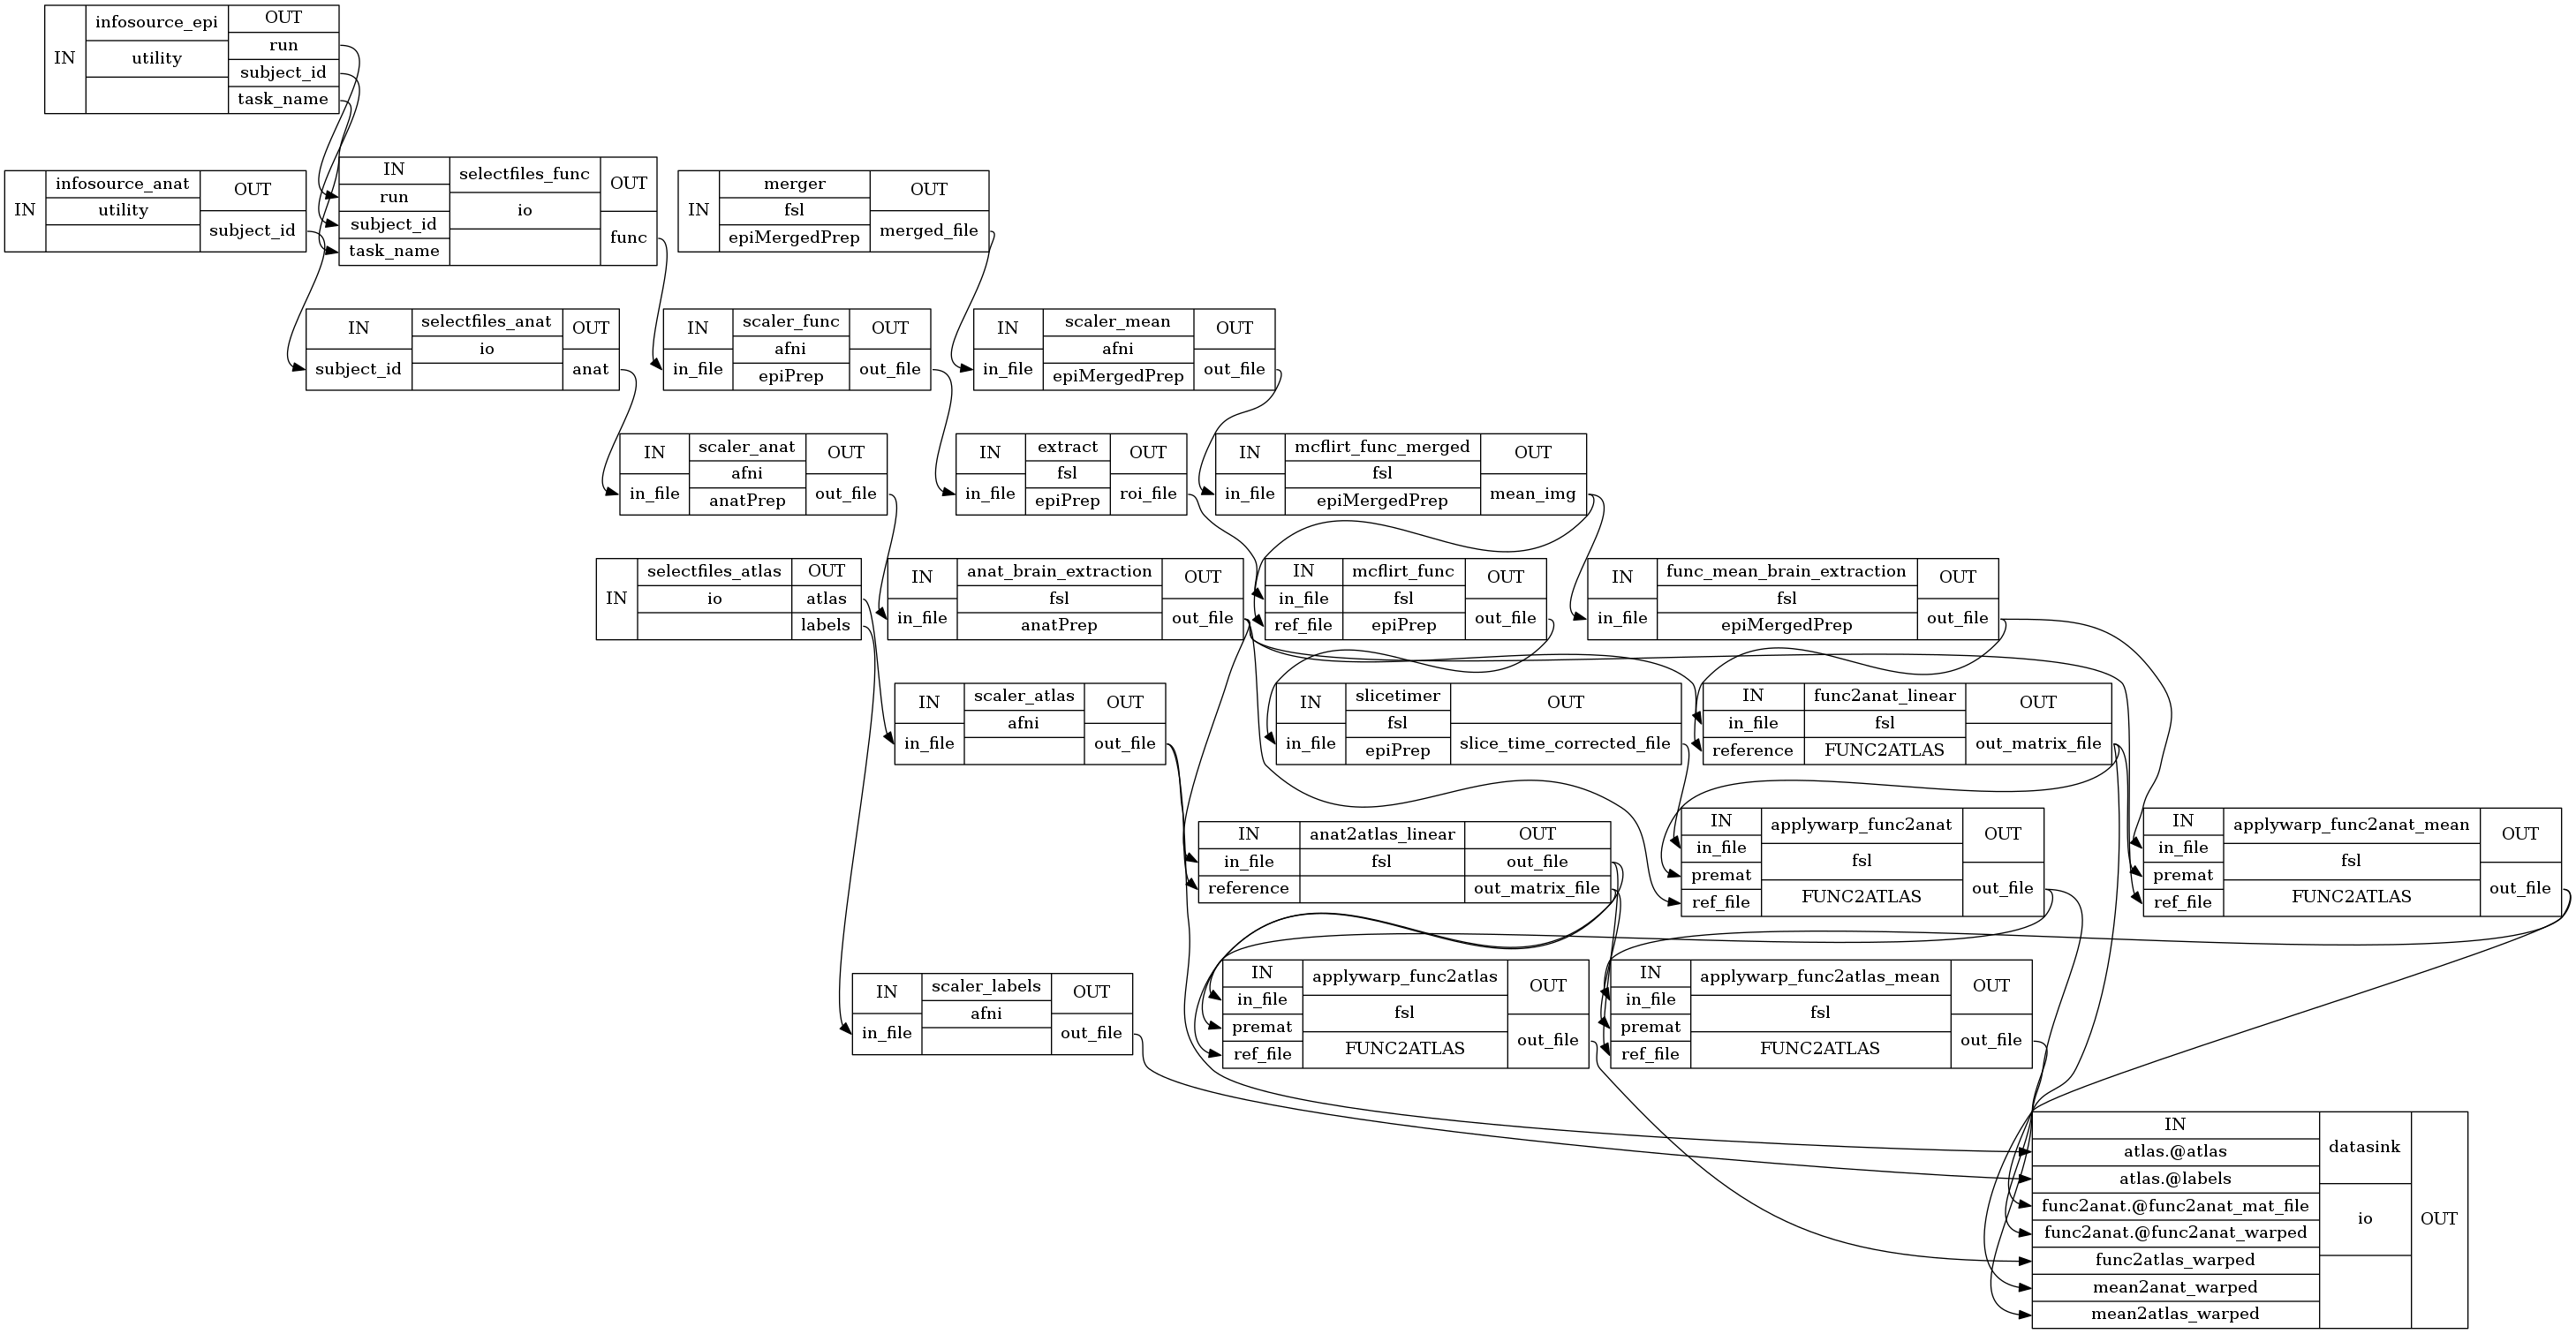

In [70]:
# Visualize the detailed graph
from IPython.display import Image
prepFlow.write_graph(graph2use='flat', format='png', simple_form=False)
Image(filename=opj(prepFlow.base_dir, 'prepFlow', 'graph_detailed.png'))

In [71]:
# running the workflow
prepFlow.run('MultiProc', plugin_args={'n_procs': 8})

210101-10:03:46,543 nipype.workflow INFO:
	 Workflow prepFlow settings: ['check', 'execution', 'logging', 'monitoring']
210101-10:03:46,583 nipype.workflow INFO:
	 Running in parallel.
210101-10:03:46,589 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 5 jobs ready. Free memory (GB): 42.29/42.29, Free processors: 8/8.
210101-10:03:46,736 nipype.workflow INFO:
	 [Job 9] Cached (prepFlow.epiMergedPrep.merger).
210101-10:03:46,734 nipype.workflow INFO:
	 [Node] Setting-up "prepFlow.selectfiles_anat" in "/data/testDS/mouse_main/output/working_dir/prepFlow/_subject_id_01/selectfiles_anat".
210101-10:03:46,737 nipype.workflow INFO:
	 [Node] Setting-up "prepFlow.selectfiles_func" in "/data/testDS/mouse_main/output/working_dir/prepFlow/_run_5_subject_id_01_task_name_4W/selectfiles_func".210101-10:03:46,737 nipype.workflow INFO:
	 [Node] Setting-up "prepFlow.selectfiles_func" in "/data/testDS/mouse_main/output/working_dir/prepFlow/_run_4_subject_id_01_task_name_4W/selectfiles_func".
21

In [74]:
os.listdir(opj(output_dir,'mean2atlas_warped', 'sub-01'))

['sub-01_ses-20201203_ATLAS_task-4W_acq-EPI_run-4_bold_merged.nii.gz_mean_reg_brain_warp_warp.nii.gz',
 'sub-01_ses-20201203_ATLAS_task-4W_acq-EPI_run-4_bold_merged_mean_brain_warp_warp.nii.gz']

In [50]:
mean2atlas_path = opj(output_dir, 'mean2atlas_warped', 'sub-01','sub-01_ses-20201203_ATLAS_task-4W_acq-EPI_run-4_bold_merged.nii.gz_mean_reg_brain_warp_warp.nii.gz')
atlas = opj(output_dir,'atlas','scaled_template.nii.gz')
labels = opj(output_dir, 'atlas', 'scaled_labels.nii.gz')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/plotting/displays.py:99: UserWarning: linewidths is ignored by contourf
  **kwargs)


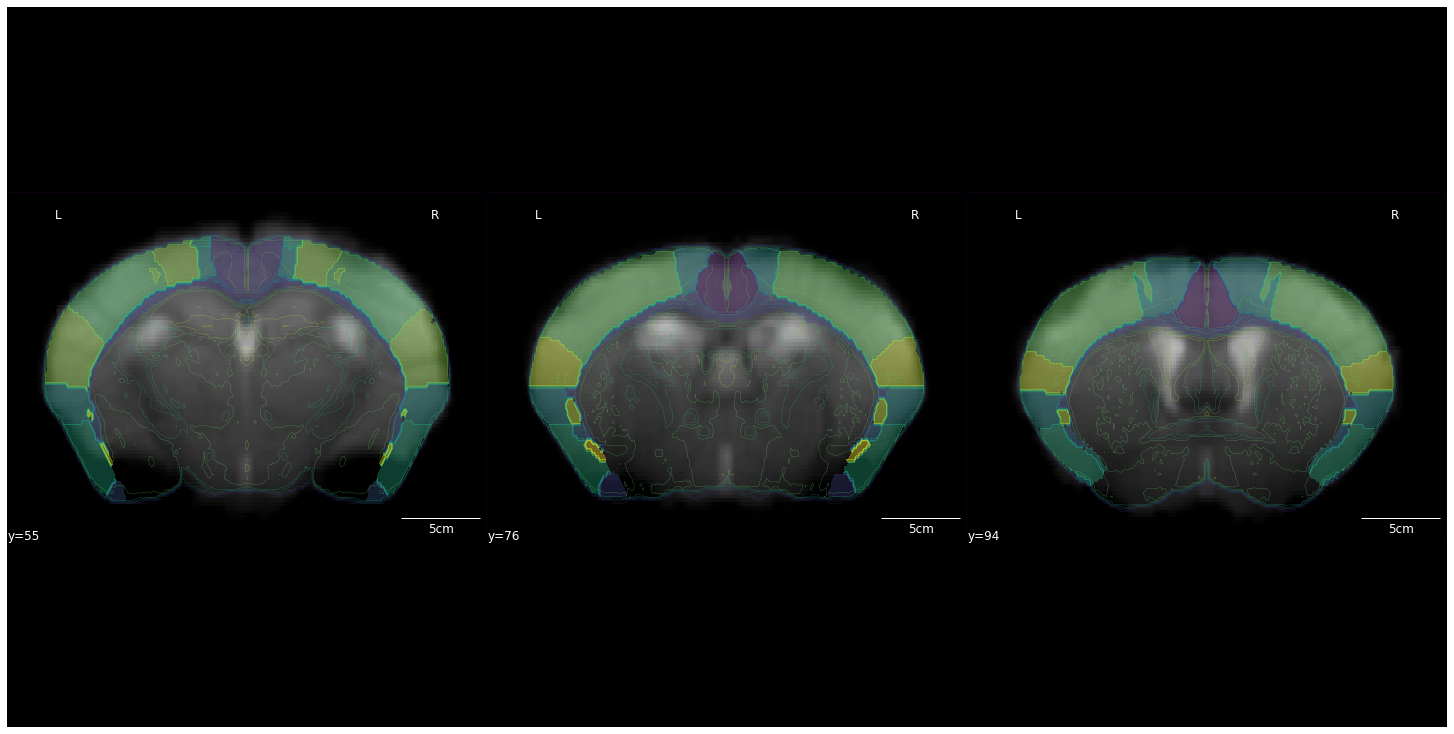

In [52]:
fig = plt.figure(figsize=(20,10))
d = plot_anat(mean2atlas_path, display_mode='y', cut_coords=[55,76,94], figure=fig)
d.add_contours(atlas, levels=np.linspace(1,np.max(nib.load(atlas).dataobj),10), alpha=0.7, linewidths=.3)
d.add_contours(labels, linewidths=.7, filled=True, alpha=0.36)
d.annotate(scalebar=True)

In [ ]:
fig = plt.figure(figsize=(20,10))
d = plot_anat(mean2anat_lin, display_mode='z', cut_coords=[5,17,29], figure=fig)
d.add_contours(atlas_scaled, levels=np.linspace(1,np.max(nib.load(atlas_scaled).dataobj),10), alpha=0.7, linewidths=.3)
d.add_contours(labels_scaled, linewidths=.7, filled=True, alpha=0.36)
d.annotate(scalebar=True)

In [ ]:
from nilearn import plotting

In [ ]:
fig = plt.figure(figsize=(20,10))
d = plot_anat(mean2anat_lin, display_mode='y', cut_coords=[55,76,94], figure=fig)
d.add_contours(atlas_scaled, levels=np.linspace(1,np.max(nib.load(atlas_scaled).dataobj),10), alpha=0.7, linewidths=.3)
d.add_contours(labels_scaled, linewidths=.7, filled=True, alpha=0.36)
d.annotate(scalebar=True)

In [ ]:
os.listdir(opj(prepFlow.base_dir,'prepFlow'))

In [ ]:
from xml.dom import minidom
# parse an xml file by name
labels_xml_path = opj(atlas_path, 'AMBMC_cortex_labels.xml')

mydoc = minidom.parse(labels_xml_path)
items = mydoc.getElementsByTagName('label')

labels = []
for i in range(len(items)):
    labels.append(items[i].firstChild.data)
print(labels[1:5])


print(f'number of labels = {len(items[1:])}')

In [ ]:
from nipype.interfaces.nilearn import SignalExtraction
seinterface = SignalExtraction()
seinterface.inputs.in_file = func2atlas_lin
seinterface.inputs.label_files = labels_scaled
seinterface.inputs.class_labels = labels[1:]
#segments = labels[1:5]
seinterface.run()

In [ ]:
SignalExtraction.help()

In [ ]:
seinterface_out = seinterface.aggregate_outputs()
signal = seinterface_out.out_file

In [ ]:
import pandas as pd

In [ ]:
pd.read_csv(signal, sep='\t', header=0)

In [ ]:
fig = plt.figure(figsize=(20,10))
d = plot_anat(mean_brain, display_mode='y', cut_coords=3, figure=fig)
#d.add_contours(atlas_scaled, levels=np.linspace(1,np.max(nib.load(atlas_scaled).dataobj),10), alpha=0.7, linewidths=1.0)
d.annotate(scalebar=True)

In [ ]:
fig = plt.figure(figsize=(20,3))
d = plot_anat(anat_brain, display_mode='z', cut_coords=[5, 25, 35], figure=fig)
d.add_contours(mean_brain, levels=np.linspace(1,np.max(nib.load(mean_brain).dataobj),10), alpha=0.7, linewidths=1.0)
d.annotate(scalebar=True)

In [ ]:
lin_1 = FLIRT()
lin_1.inputs.in_file = mean_brain
lin_1.inputs.reference = anat_brain
lin_1.inputs.interp ='nearestneighbour'
lin_1.inputs.cost = 'normmi'
lin_1.inputs.dof = 6
lin_1.run()

In [ ]:
lin_1_out = lin_1.aggregate_outputs()
func2anat_lin_1 = lin_1_out.out_file
func2anat_lin_1_mat = lin_1_out.out_matrix_file

In [ ]:
fig = plt.figure(figsize=(20,3))
d = plot_anat(anat_brain, display_mode='z', cut_coords=[5, 25, 35], figure=fig)
d.add_contours(func2anat_lin_1, levels=np.linspace(1,np.max(nib.load(mean_brain).dataobj),10), alpha=0.7, linewidths=1.0)
d.annotate(scalebar=True)

In [ ]:
lin_2 = FLIRT()
lin_2.inputs.in_file = anat_brain
lin_2.inputs.reference = atlas_scaled
lin_2.inputs.interp ='spline'
lin_2.inputs.cost = 'normmi'
lin_2.inputs.dof = 12
lin_2.run()

In [ ]:
lin_2_out = lin_2.aggregate_outputs()
anat2atlas_lin_2 = lin_2_out.out_file
anat2atlas_lin_2_mat = lin_2_out.out_matrix_file

In [ ]:
fig = plt.figure(figsize=(20,7))
d = plot_anat(anat2atlas_lin_2, display_mode='y', cut_coords=[35,66,94], figure=fig)
#d.add_contours(atlas_scaled, levels=np.linspace(1,np.max(nib.load(atlas_scaled).dataobj),10), alpha=0.7, linewidths=1.0)
d.annotate(scalebar=True)

In [ ]:
os.listdir(opj(prepFlow.base_dir,'prepFlow','anatPrep','_run_4_subject_id_01_task_name_4W','brain_extraction','sub-01_ses-20201203_ATLAS_acq-FLASH_T1w_brain.nii.gz'))

In [ ]:
applywarp =  ApplyWarp()
applywarp.inputs.in_file=func2anat_lin_1
applywarp.inputs.output_type='NIFTI_GZ'
applywarp.inputs.ref_file=anat2atlas_lin_2
applywarp.inputs.premat=anat2atlas_lin_2_mat
applywarp.run()

In [ ]:
applywarp_out = applywarp.aggregate_outputs()
func_warped = applywarp_out.out_file

In [ ]:
fig = plt.figure(figsize=(20,7))
d = plot_anat(func_warped, display_mode='y', cut_coords=[35,66,94], figure=fig)
#d.add_contours(atlas_scaled, levels=np.linspace(1,np.max(nib.load(atlas_scaled).dataobj),10), alpha=0.3, linewidths=1.0)
#d.add_contours(atlas_scaled, levels=np.linspace(1,np.max(nib.load(la).dataobj),10), alpha=0.3, linewidths=1.0)
d.annotate(scalebar=True)

In [ ]:
fig = plt.figure(figsize=(20,7))
d = plot_anat(mean_img(EPI_files[0]), display_mode='y', cut_coords=3, figure=fig)
#d.add_contours(atlas_scaled, levels=np.linspace(1,np.max(nib.load(atlas_scaled).dataobj),10), alpha=0.7, linewidths=1.0)
#d.annotate(scalebar=True)

In [ ]:
lin = FLIRT()
lin.inputs.in_file = anat_brain_extraction
lin.inputs.reference = atlas_scaled
lin.inputs.interp ='nearestneighbour'
lin.inputs.cost = 'normmi'
lin.inputs.dof = 6
lin.run()

In [ ]:
FLIRT.help()

In [ ]:
lin_out = lin.aggregate_outputs()
func2anat_lin = lin_out.out_file
func2anat_lin_mat = lin_out.out_matrix_file

In [ ]:
cost: ('mutualinfo' or 'corratio' or 'normcorr' or 'normmi' or
                  'leastsq' or 'labeldiff' or 'bbr')
                cost function

In [ ]:
lin_ANTS = RegistrationSynQuick()
lin_ANTS.inputs.fixed_image = atlas_scaled
lin_ANTS.inputs.moving_image = mean_brain
lin_ANTS.inputs.transform_type = 'a'
lin_ANTS.run()

In [ ]:
lin_ANTS_out = lin_ANTS.aggregate_outputs()
anat_lin_ANTS = lin_ANTS_out.warped_image

In [ ]:
fig = plt.figure(figsize=(20,3))
d = plot_anat(func2anat_lin, display_mode='y', cut_coords=[35,66,94], figure=fig)
d.add_contours(anat2atlas_lin, levels=np.linspace(1,np.max(nib.load(anat2atlas_lin).dataobj),10), alpha=0.7, linewidths=1.0)
d.annotate(scalebar=True)

In [ ]:
fig = plt.figure(figsize=(20,3))
d = plot_anat(out_file, display_mode='y', cut_coords=[35,66,94], figure=fig)
d.add_contours(anat2atlas_lin, levels=np.linspace(1,np.max(nib.load(anat2atlas_lin).dataobj),10), alpha=0.7, linewidths=1.0)
d.annotate(scalebar=True)

In [ ]:
fig = plt.figure(figsize=(20,3))
d = plot_anat(anat_lin_ANTS, display_mode='y', cut_coords=[35,66,94], figure=fig)
d.add_contours(atlas_scaled, levels=np.linspace(1,np.max(nib.load(atlas_scaled).dataobj),10), alpha=0.7, linewidths=1.0)
d.annotate(scalebar=True)

In [ ]:
nonlin = FNIRT()
nonlin.inputs.in_file = anat_brain_scaled_path
nonlin.inputs.ref_file = atlas_scaled
nonlin.inputs.affine_file = anat_lin_mat
nonlin.inputs.jacobian_range=0.1,10
nonlin.inputs.warp_resolution=15,15,15
nonlin.inputs.subsampling_scheme = [8, 4, 2, 2]
nonlin.run()

In [ ]:
BET.help()

In [ ]:
nonlin_out = nonlin.aggregate_outputs()
anat_nonlin = nonlin_out.warped_file

In [ ]:
fig = plt.figure(figsize=(20,3))
d = plot_anat(anat_nonlin, display_mode='y', cut_coords=10, figure=fig)
d.add_contours(atlas_scaled, levels=np.linspace(1,np.max(nib.load(atlas_scaled).dataobj),10), alpha=0.7, linewidths=1.0)
d.annotate(scalebar=True)

In [ ]:
out = '/tmp/tmpurp3xhgk/dataPrep/merger/sub-01_ses-20201203_ATLAS_task-4W_acq-EPI_run-4_bold_merged.nii.gz'
os.path.exists(out)

In [ ]:
mcf = MCFLIRT()
mcf.inputs.in_file = scaler_m_out.out_file
mcf.inputs.ref_vol=30
mcf.inputs.dof=6
mcf.inputs.mean_vol=True
mcf.inputs.smooth = 0.0
#mcf.inputs.cost = 'normmi'
#mcf.inputs.output_type='NIFTI_GZ'
mcf.run()

In [ ]:
MCFLIRT.help()

In [ ]:
mcf_out = mcf.aggregate_outputs()
mcf_out

In [ ]:
f2a = FLIRT()
f2a.inputs.in_file=mcf_out.mean_img
f2a.inputs.reference=scaler_a_out.out_file # target: FLASH - weighted
f2a.inputs.dof=6
f2a.inputs.no_resample_blur=True # normizied mutual info
f2a.inputs.cost = 'normmi'
#f2a.inputs.interp = 'spline'
f2a.run()

In [ ]:
f2a_out = f2a.aggregate_outputs()

In [ ]:
 or 'corratio' or 'normcorr' or 'normmi' or
                  'leastsq' or 'labeldiff' or 'bbr'

In [ ]:
fig = plt.figure(figsize=(20,10))
dis = plot_anat(f2a_out.out_file, display_mode='y', cut_coords=[-85,-40,0], figure=fig)
dis.add_contours(anat_scaled, levels=np.linspace(20, np.max(nib.load(anat_scaled).dataobj), 7))
dis.annotate(scalebar=True)

In [ ]:
afni_mc_func = Node(Volreg(in_file = merged_scaled, interp = 'linear', outputtype = 'NIFTI', zpad = 1,  num_threads=4, in_weight_volume = (EPI_files[0], 30)),
                   name='motion_corr_func')
afni_mc_func.run()

In [ ]:
afni_epi_mc = '/tmp/tmp8fjct3l9/motion_corr_func/sub-01_ses-20201203_ATLAS_task-4W_acq-EPI_run-4_bold_merged_volreg.nii'
nib.load(afni_epi_mc).shape

In [ ]:
fig = plt.figure(figsize=(20,10))
dis = plot_anat(mean_img(afni_epi_mc), display_mode='y', cut_coords=3, figure=fig)
#dis.add_contours(anat_scaled)
dis.annotate(scalebar=True)

In [ ]:
func2anat_linear = Node(FLIRT(in_file=afni_epi_mc,
                       reference=anat_scaled,# target: FLASH - weighted
                       dof=6,
                       cost_func = 'mutualinfo',       
                       interp='trilinear'), # normizied mutual info
             name="func2anat_linear")
func2anat_linear.run()

In [ ]:
fig = plt.figure(figsize=(20,10))
dis = plot_anat(mean_img(allign_out.epi_al_orig), display_mode='y', cut_coords=3, figure=fig)
#dis.add_contours(anat_scaled)
dis.annotate(scalebar=True)

In [ ]:
RegistrationSynQuick.help()

In [ ]:
from nipype.interfaces.afni import AlignEpiAnatPy, Allineate

In [ ]:
allign = AlignEpiAnatPy()
allign.inputs.in_file = mcf_out.mean_img
allign.inputs.anat = anat_scaled
allign.inputs.epi2anat = True
#allign.inputs.epi2anat = True
allign.inputs.tshift = 'off'
allign.inputs.epi_base = 30
allign.inputs.save_skullstrip = False
allign.inputs.epi_strip = 'None'
allign.inputs.outputtype = 'NIFTI_GZ'
allign.run()

In [ ]:
allign_out = allign.aggregate_outputs()

In [ ]:
allignate = Allineate()
allignate.inputs.in_file = mcf_out.mean_img
allignate.inputs.reference = anat_scaled

In [ ]:
allignate.help()


In [ ]:
fig = plt.figure(figsize=(20,10))
dis = plot_anat(allign_out.epi_al_orig, display_mode='y', cut_coords=3, figure=fig)
#dis.add_contours(anat_scaled)
dis.annotate(scalebar=True)